# Libraries

"gensim" (library for natural language processing), "bertopic" (BERT based topic model) and "sentence-transformers" (provides pre-trained BERT models) are installed.

In [ ]:
!pip install -q gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.8 MB/s eta 0:00:00


In [ ]:
!pip install -q bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install -q sentence-transformers

All the libraries and functions needed to execute the code in the notebok are imported.

In [ ]:
# General
import pickle
import re
import numpy as np
import random
import math
import itertools
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm

# Preprocessing
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from gensim.corpora import Dictionary

# Models
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF, TruncatedSVD
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Mounted at /content/drive


In [ ]:
# Set the base path if needed
base_path = '/content/drive/My Drive'

The custom functons defined in `Function_Setup.ipynb` are imported.

In [ ]:
import sys

sys.path.append(f'{base_path}/Text_Mining_Project_881765_933735')

from text_mining_project_utils import (set_feature_names, set_dictionary, set_texts,
                                       set_top_words,set_vectorizer, get_topics,
                                       get_diversity, get_coherence,create_space,
                                       tuning_tester, set_params, plot_top_words,
                                       tuning_plotter, plot_metrics)

# Importing The Data

The summarized document data created in `3_Text_Summarization.ipynb` is loaded.

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/summarized_docs', "rb") as fp:
  docs = pickle.load(fp)

# Tokenization and Vectorization

A custom list of stop words is creted and joined together with NLTK's stop word list.

In [ ]:
my_stop_words = {'say', 'be', 'said', 'says', 'saying', "tell", "told", "also", "year", "years",
                 "people", "mr", "mrs", "ms", "report", "according", "man", "men", "woman", "women", "one", "two", "three",
                 "four", "five", "six", "seven", "eight", "nine", "ten"}

stop_words = set(nltk.corpus.stopwords.words('english'))

stop_words = stop_words.union(my_stop_words)

Each document is stripped of any non alphabetic character and then its words are tokenized and lemmatized, given that they are not stop words wich are removed.

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def tokenizer(doc):
  doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
  doc = doc.lower()
  tokens = nltk.word_tokenize(doc)
  processed_doc = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
  return processed_doc

start = time()

processed_docs = [tokenizer(doc) for doc in docs]

end = time()
print("Tokenization executed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Tokenization executed in 0 minutes and 44 seconds.


An instance of Gensim dictionary is created, with terms that appear in no less than 0.1% and no more than 80% of the documents with a limit of 20000 terms, it will be used in the count vectorizer and to compute topic coherence.

In [ ]:
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below = int(len(processed_docs)*0.001),
                           no_above = 0.8,
                           keep_n = 20000
                           )

Processed documents' tokens are joined in strings to be passed to a CountVectorizer that computes the Count Matrix, then this matrix is used to compute normalized Tf and Tf-Idf matrices. These variables are stored in the ` X_tf`, `X_tf_norm` and `X_tfidf` variables.

In [ ]:
processed_string_docs = [' '.join(doc) for doc in processed_docs]

count_vectorizer = CountVectorizer(vocabulary = dictionary.token2id)

X_tf = count_vectorizer.transform(processed_string_docs)

tf_transformer = TfidfTransformer(use_idf=False)
X_tf_norm = tf_transformer.fit_transform(X_tf)

tfidf_transformer = TfidfTransformer(use_idf=True)
X_tfidf = tfidf_transformer.fit_transform(X_tf)

A subset of 10000 examples is created for each of the vectors to run the hyperparameter tuning.

In [ ]:
X_tf_subset = X_tf[:10000]

X_tfidf_subset = X_tfidf[:10000]

X_tf_norm_subset = X_tf_norm[:10000]

A new Tf-Idf vectorizer is fitted with the entire corpus to be used to compute Diversity (see the function  ```get_diversity``` in the function setup notebook).

In [ ]:
ntexts = [' '.join(doc) for doc in processed_docs]

vectorizer = TfidfVectorizer(max_features=None, stop_words="english")

vectorizer.fit(ntexts);

The terms are stored as strings in the variable ```feature_names```.



In [ ]:
feature_names = count_vectorizer.get_feature_names_out()

The variales needed to run the functions from the custom package are set.

In [ ]:
# To get the topics
set_feature_names(feature_names)

# Text for the Gensim coherence
set_dictionary(dictionary)

# Text for the Gensim coherence
set_texts(processed_docs)

# Keep top 10 words
set_top_words(10)

# TF-idf vectorizer for the diversity
set_vectorizer(vectorizer)

# Models

## LSA

An instance of sklearn's TruncatedSVD is created to implement LSA. To find the best value for the hyperparameter `n_components` some values are tested with the `tuning_tester()` function.

In [ ]:
lsa = TruncatedSVD()

param_grid = {"n_components": [10, 20, 30, 40]
              }

start = time()

results = tuning_tester(model = lsa,
                        param_grid = param_grid,
                        data = X_tfidf_subset
                        )

end = time()
print("Hyperparameter search executed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Evaluating model:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Hyperparameter search executed in 0 minutes and 47 seconds.


The results of the tuning tests can be displayed:

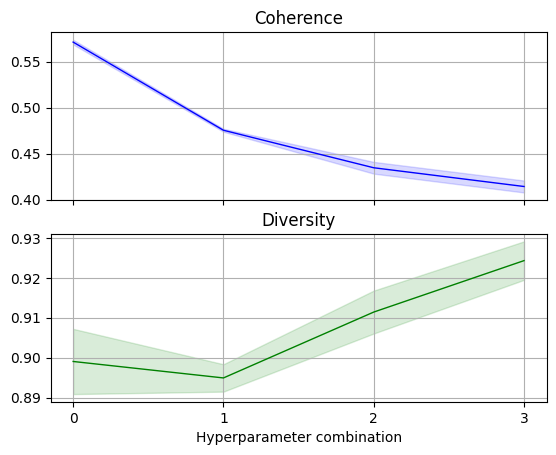

In [ ]:
tuning_plotter(results)

The iteration that best combines diversity and coherence seems to be the first one, so it is set with the `set_params()` function, its hyperparameters are then printed.

In [ ]:
lsa = set_params(lsa, param_grid, best_iter=0)
lsa.get_params()

{'algorithm': 'randomized',
 'n_components': 10,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 15,
 'tol': 0.0}

The model is finally fitted on the full data.

In [ ]:
start = time()

lsa.fit(X_tfidf)

end = time()
print("Model fitted in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Model fitted in 0 minutes and 1 seconds.


The top 10 most frequent words present in each of the 10 topics can be displayed, along with their respective frequencies.

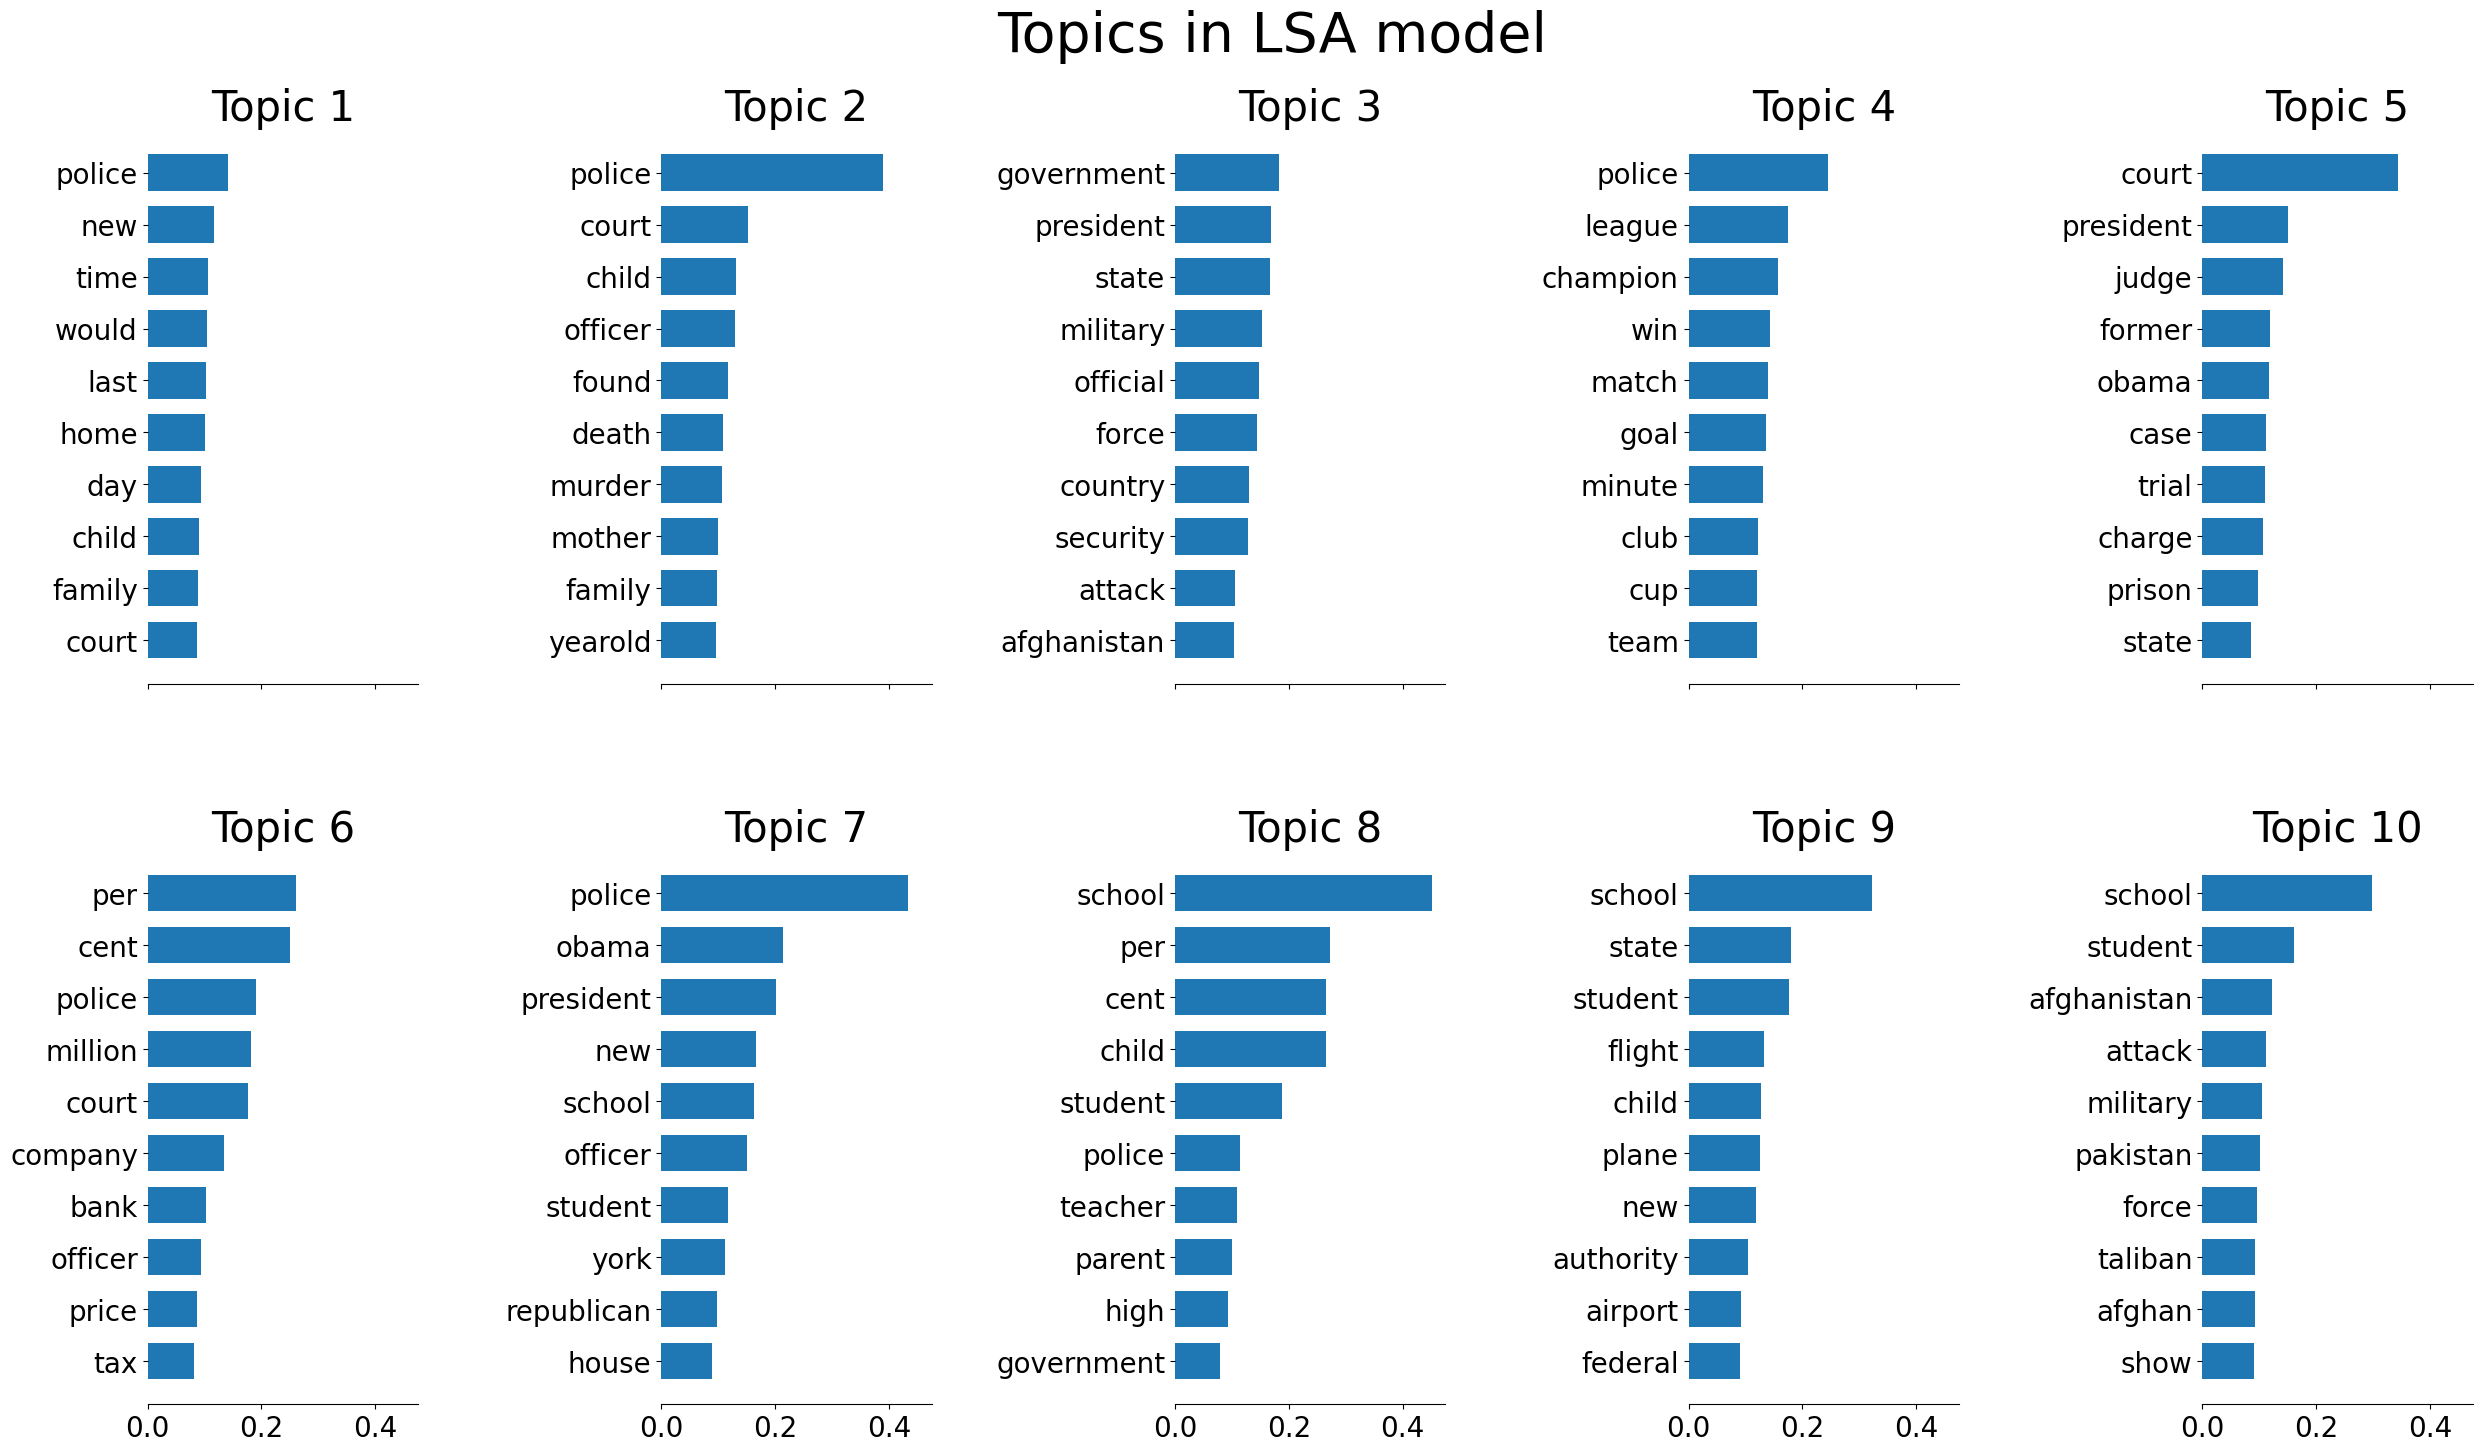

In [ ]:
plot_top_words(lsa, "Topics in LSA model")

## LDA

An instance of sklearn's LatentDirichletAllocation is created to implement LDA. To find the best value for the hyperparameter `n_components` some values are tested with the `tuning_tester()` function.

In [ ]:
lda = LatentDirichletAllocation(learning_method = "online")

param_grid = {"n_components": [10, 20, 30, 40]
              }

start = time()

results = tuning_tester(model = lda,
                        param_grid = param_grid,
                        data = X_tf_subset
                        )

end = time()
print("Hyperparameter search executed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Evaluating model:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Hyperparameter search executed in 7 minutes and 59 seconds.


The results of the tuning tests can be displayed:

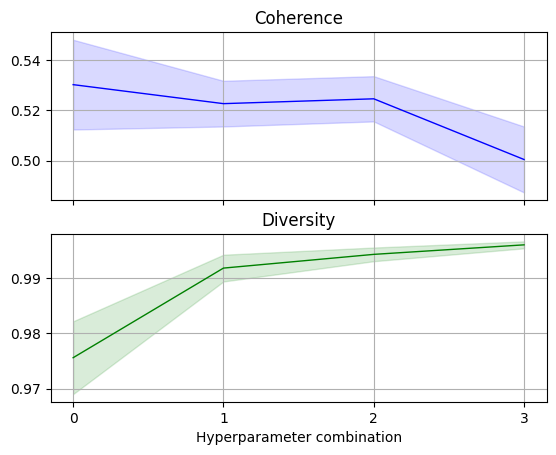

In [ ]:
tuning_plotter(results)

The iteration that best combines diversity and coherence seems to be the second one, so it is set with the `set_params()` function, its hyperparameters are then printed.

In [ ]:
lda = set_params(lda, param_grid, best_iter=2)
lda.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 30,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 15,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

The model is finally fitted on the full data.

In [ ]:
start = time()

lda.fit(X_tf)

end = time()
print("Model fitted in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Model fitted in 3 minutes and 4 seconds.


The top 10 most frequent words present in 10 of the topics can be displayed, along with their respective frequencies.

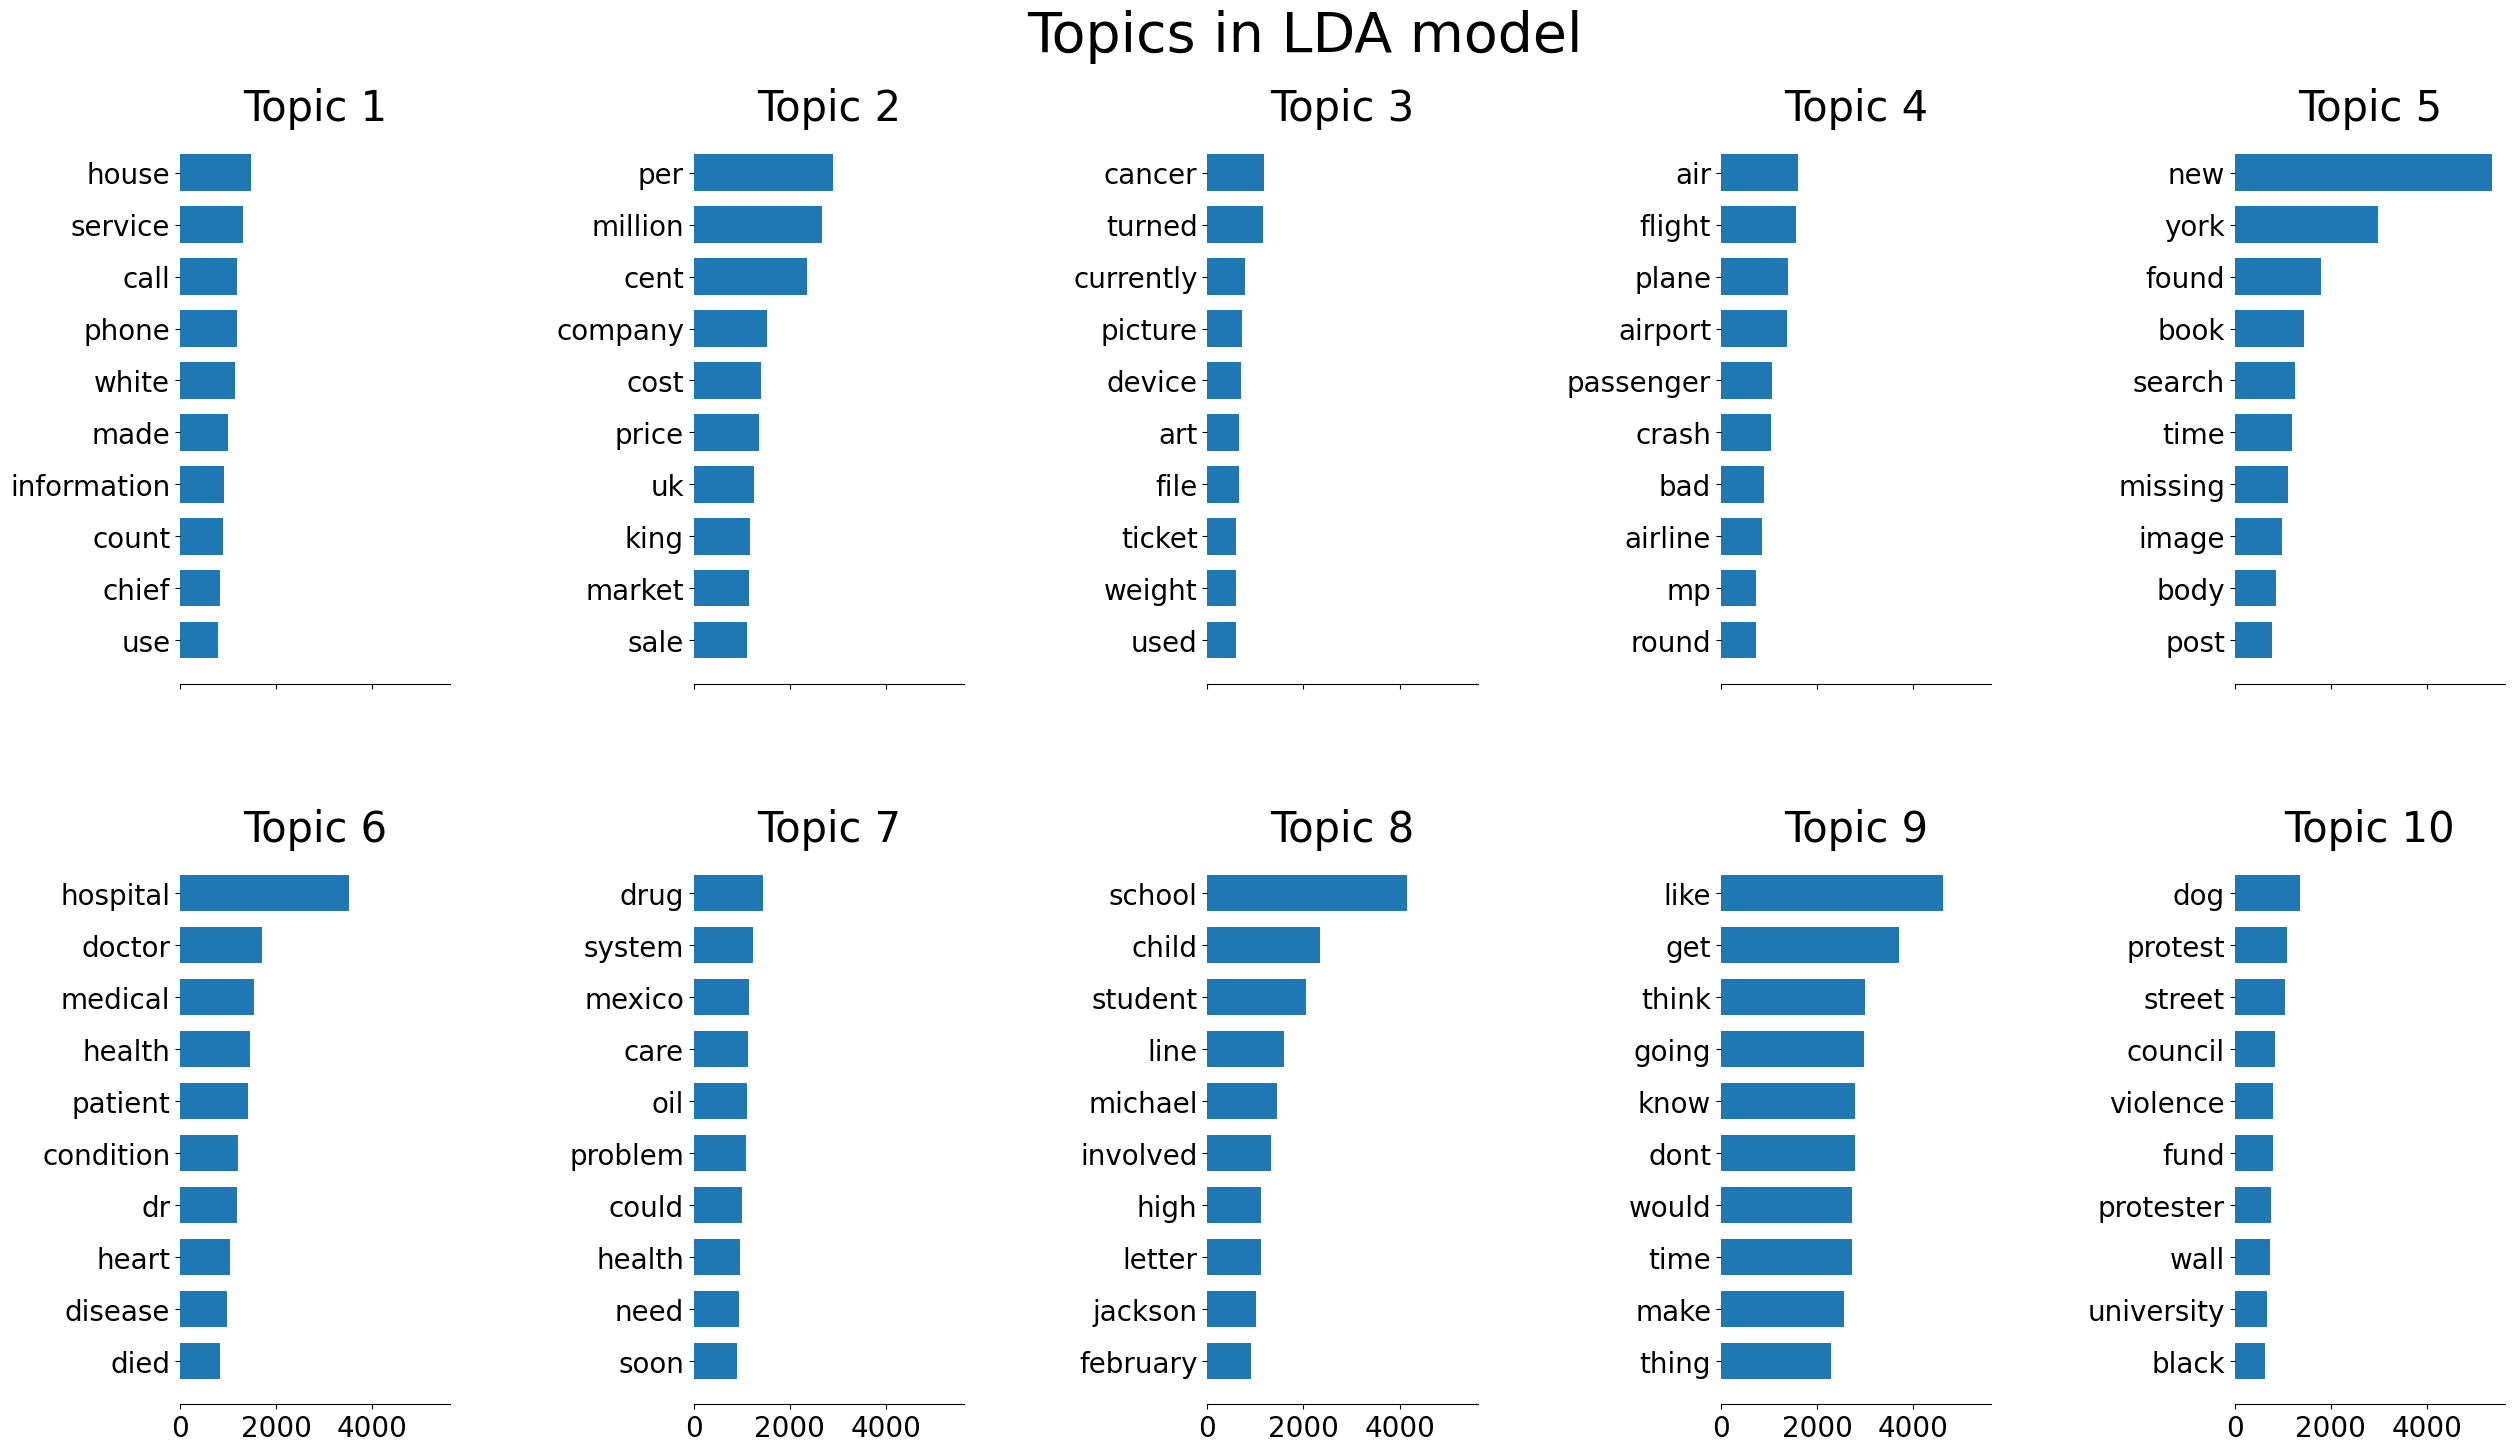

In [ ]:
plot_top_words(lda, "Topics in LDA model")

## pLSA

An instance of sklearn's NMF is created to implement pLSA, so the arguments `init`, `beta_loss` and `solver` are respectively set to: `"nndsvda"`, `"kullback-leibler"` and `"mu"`. To find the best value for the hyperparameter `n_components` some values are tested with the `tuning_tester()` function.

In [ ]:
plsa = NMF(init = "nndsvda",
          beta_loss = "kullback-leibler",
          solver = "mu"
          )

param_grid = {"n_components": [20, 30, 40, 50]
              }

start = time()

results = tuning_tester(model = plsa,
                        param_grid = param_grid,
                        data = X_tf_norm_subset
                        )

end = time()
print("Hyperparameter search executed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Evaluating model:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating seed:   0%|          | 0/3 [00:00<?, ?it/s]

Hyperparameter search executed in 7 minutes and 18 seconds.


The results of the tuning tests can be displayed:

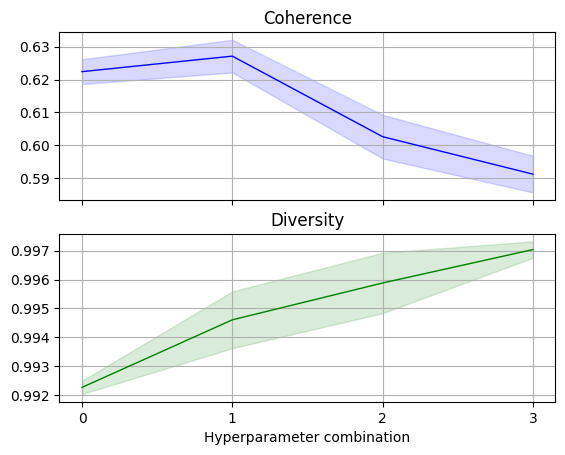

In [ ]:
tuning_plotter(results)

The iteration that best combines diversity and coherence seems to be the second one, so it is set with the `set_params()` function, its hyperparameters are then printed.

In [ ]:
plsa = set_params(plsa, param_grid, best_iter=1)
plsa.get_params()

{'alpha_H': 'same',
 'alpha_W': 0.0,
 'beta_loss': 'kullback-leibler',
 'init': 'nndsvda',
 'l1_ratio': 0.0,
 'max_iter': 200,
 'n_components': 30,
 'random_state': 15,
 'shuffle': False,
 'solver': 'mu',
 'tol': 0.0001,
 'verbose': 0}

The model is finally fitted on the full data.

In [ ]:
start = time()

plsa.fit(X_tf_norm)

end = time()
print("Model fitted in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Model fitted in 2 minutes and 56 seconds.


The top 10 most frequent words present in 10 of the topics can be displayed, along with their respective frequencies.

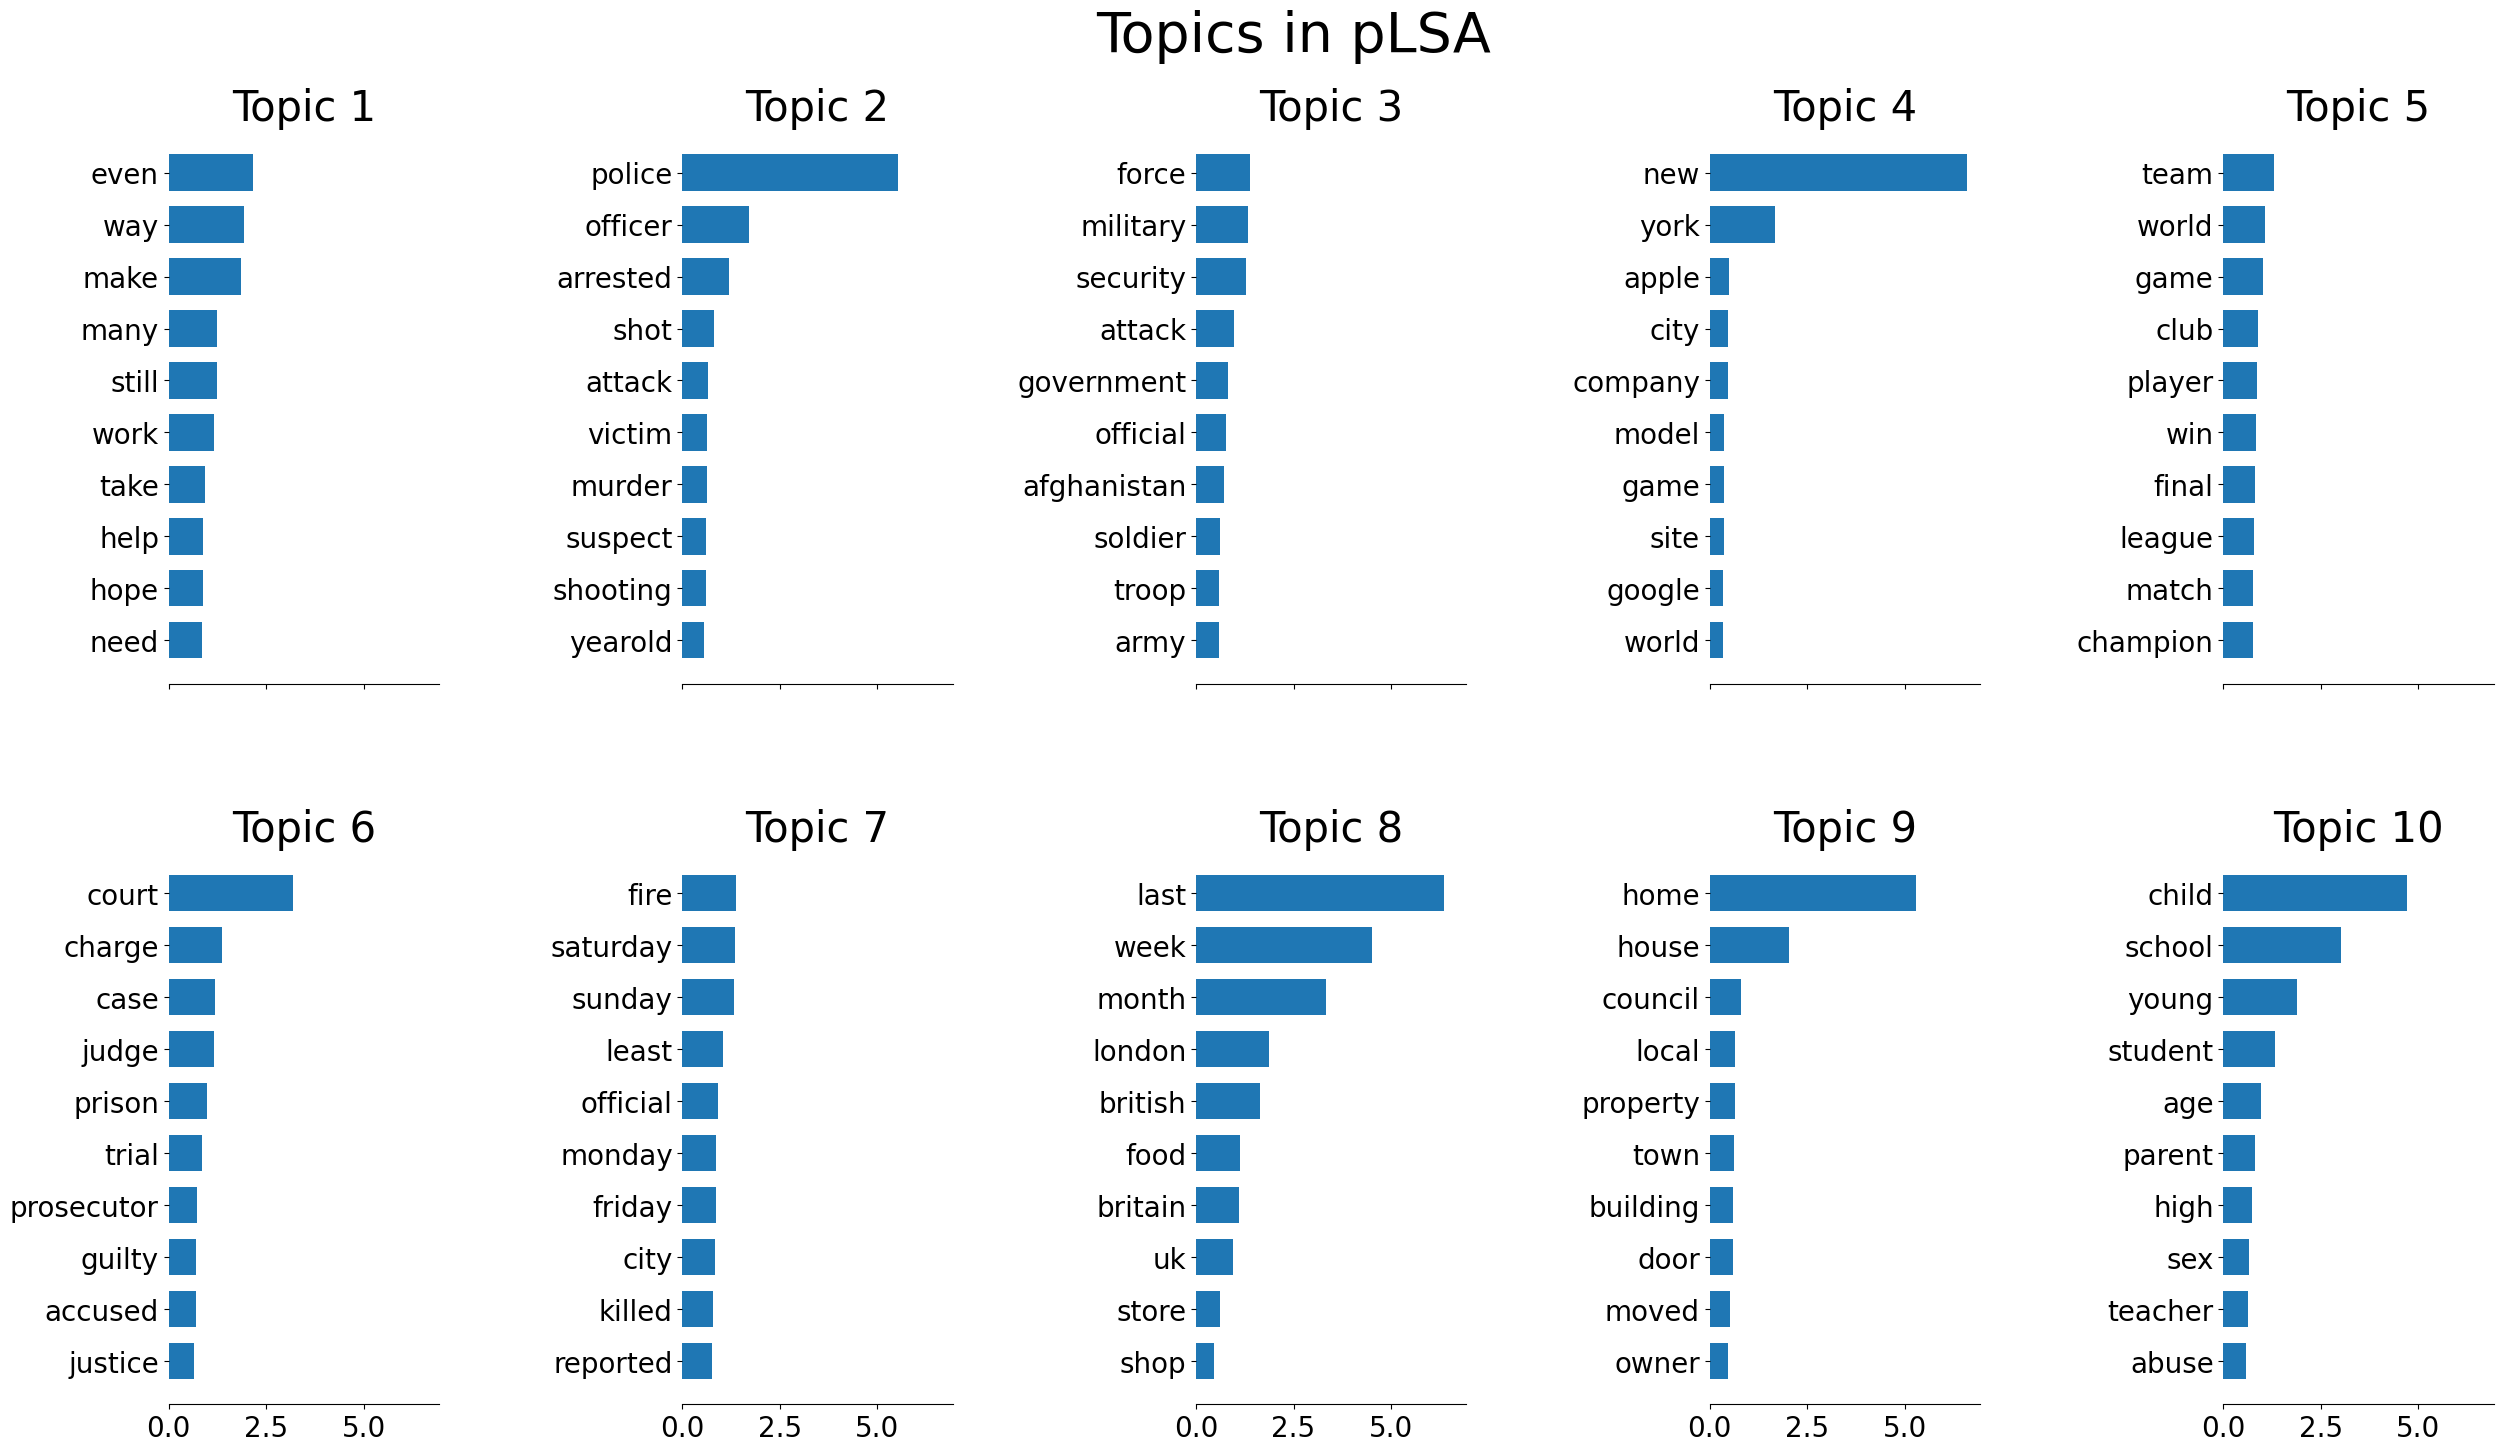

In [ ]:
plot_top_words(plsa, "Topics in pLSA")

## BERTopic

The embedding model is created first, to make sure it runs on GPU (by passing `device='cuda'` argument), an istance of BERTopic is then created. This model is then fitted on the whole raw document data.

In [ ]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
bert = BERTopic(embedding_model=embed_model, calculate_probabilities=True, verbose=1)

start = time()

bert_topics, probs = bert.fit_transform(docs)

end = time()
print("Model fitted in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

2026-01-12 08:04:44,410 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1559 [00:00<?, ?it/s]

2026-01-12 08:06:29,000 - BERTopic - Embedding - Completed ✓
2026-01-12 08:06:29,002 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-12 08:07:41,632 - BERTopic - Dimensionality - Completed ✓
2026-01-12 08:07:41,634 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-12 08:43:26,750 - BERTopic - Cluster - Completed ✓
2026-01-12 08:43:26,780 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-12 08:43:32,998 - BERTopic - Representation - Completed ✓


Model fitted in 38 minutes and 54 seconds.


The top 5 most frequent words present in 8 of the topics can be displayed, along with their respective frequencies.

In [ ]:
bert.visualize_barchart(top_n_topics=8)

# Evaluation

Both the diversity and coherence for all of the four models can be displayed together as bar plots with the `plot_metrics()` function.

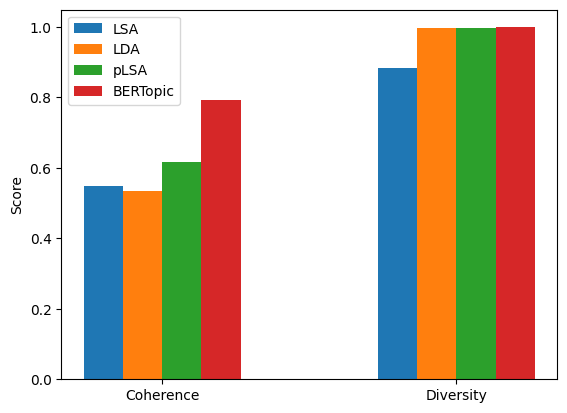

In [ ]:
plot_metrics([(lsa,False), (lda,False), (plsa,False), (bert,True)],
             ["LSA", "LDA", "pLSA", "BERTopic"])